In [197]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import csv
from sklearn.linear_model import Ridge


In [198]:
df_hospital=pd.read_csv("processed_data/dublinbikes_james_hospital.csv")
df_portobello=pd.read_csv("processed_data/dublinbikes_portobello.csv")

Lets get some basic features like day of week, weekend, time

In [199]:
def get_basic_features(df:pd.DataFrame):
    df["TIME"]=pd.to_datetime(df["TIME"])
    df["DAY OF WEEK"]=df["TIME"].dt.dayofweek-1
    df["HOUR"]=df["TIME"].dt.strftime("%H").astype(int)
    df["MINUTE"]=df["TIME"].dt.strftime("%M").astype(int)

    
    return df

In [200]:
df_hospital_map={}
df_portobello_map={}

In [201]:
df_hospital = get_basic_features(df_hospital)
df_portobello = get_basic_features(df_portobello)

In [202]:
df_hospital[500:520]

,TIME,BIKE STANDS,AVAILABLE BIKES,DAY OF WEEK,HOUR,MINUTE
500,2020-01-29 17:40:02,40,12,1,17,40
501,2020-01-29 17:45:02,40,10,1,17,45
502,2020-01-29 17:50:02,40,12,1,17,50
503,2020-01-29 17:55:02,40,12,1,17,55
504,2020-01-29 18:00:02,40,13,1,18,0
505,2020-01-29 18:05:02,40,13,1,18,5
506,2020-01-29 18:10:02,40,15,1,18,10
507,2020-01-29 18:15:02,40,15,1,18,15
508,2020-01-29 18:20:02,40,14,1,18,20
509,2020-01-29 18:25:02,40,14,1,18,25


Lets add some more complex features using weekly, daily and short-term seasonality trends in the data

For short term trends lets use intervals of 15 min, and get the last three intervals

In [203]:
def get_trend_features(df:pd.DataFrame):
    
    df["5MIN"] = df["AVAILABLE BIKES"].shift(1)
    df["10MIN"] = df["AVAILABLE BIKES"].shift(2)
    df["15MIN"] = df["AVAILABLE BIKES"].shift(3)
    df["1DAY"] = df["AVAILABLE BIKES"].shift(12*24)
    df["2DAY"] = df["AVAILABLE BIKES"].shift(12*24*2)
    df["3DAY"] = df["AVAILABLE BIKES"].shift(12*24*3)
    df["1WEEK"] = df["AVAILABLE BIKES"].shift(12*24*7)
    df.dropna(inplace=True)
    return df

In [204]:
def shift_target_variable(df:pd.DataFrame, prediction_time : int):
    df=df.copy(deep=True)
    prediction_int = np.trunc(prediction_time/5) - 1
    prediction_int=prediction_int.astype(int)
    df["AVAILABLE BIKES"] = df["AVAILABLE BIKES"].shift(prediction_int)
    df.dropna(inplace=True)
    return df

In [205]:
def normalize_features(df:pd.DataFrame):
    df["AVAILABLE BIKES"] = df["AVAILABLE BIKES"]/df["BIKE STANDS"]
    df["DAY OF WEEK"] = df["DAY OF WEEK"] / 6
    df["HOUR"] = df["HOUR"] / max(df["HOUR"])
    df["MINUTE"] = df["MINUTE"] / max(df["MINUTE"])
    return df

In [206]:
df_hospital=normalize_features(df_hospital)
df_hospital=get_trend_features(df_hospital)

df_portobello=normalize_features(df_portobello)
df_portobello=get_trend_features(df_portobello)


df_hospital.set_index("TIME",inplace=True,drop=True)
df_portobello.set_index("TIME",inplace=True,drop=True)


In [207]:

df_hospital_map["10MIN"]=shift_target_variable(df_hospital,10)
df_portobello_map["10MIN"]=shift_target_variable(df_portobello,10)

df_hospital_map["30MIN"]=shift_target_variable(df_hospital,30)
df_portobello_map["30MIN"]=shift_target_variable(df_portobello,30)

df_hospital_map["60MIN"]=shift_target_variable(df_hospital,60)
df_portobello_map["60MIN"]=shift_target_variable(df_portobello, 60)



In [208]:
def get_X_and_y(df:map):
    X={}
    y={}
    y["10MIN"]=df["10MIN"]["AVAILABLE BIKES"]
    X["10MIN"] = df["10MIN"].drop(axis=1,columns=["BIKE STANDS","AVAILABLE BIKES"])
    y["30MIN"]=df["30MIN"]["AVAILABLE BIKES"]
    X["30MIN"] = df["30MIN"].drop(axis=1,columns=["BIKE STANDS","AVAILABLE BIKES"])
    y["60MIN"]=df["60MIN"]["AVAILABLE BIKES"]
    X["60MIN"] = df["60MIN"].drop(axis=1,columns=["BIKE STANDS","AVAILABLE BIKES"])
    return X,y

In [209]:
X_portobello,y_portobello=get_X_and_y(df_portobello_map)
X_hospital,y_hospital=get_X_and_y(df_hospital_map)


In [210]:
y_portobello["60MIN"][500:510]

TIME
2020-02-05 18:35:02    0.266667
2020-02-05 18:40:02    0.100000
2020-02-05 18:45:02    0.200000
2020-02-05 18:50:02    0.233333
2020-02-05 18:55:02    0.333333
2020-02-05 19:00:02    0.300000
2020-02-05 19:05:02    0.300000
2020-02-05 19:10:02    0.300000
2020-02-05 19:15:02    0.300000
2020-02-05 19:20:02    0.366667
Name: AVAILABLE BIKES, dtype: float64

In [211]:
ridge_model_portobello = {}
ridge_model_hospital = {}

for key in X_portobello.keys():
    ridge_model_portobello[key]=Ridge().fit(X_portobello[key],y_portobello[key])
    ridge_model_hospital[key]=Ridge().fit(X_hospital[key],y_hospital[key])



10MIN
30MIN
60MIN


In [212]:
df=pd.DataFrame({"Feature Name":ridge_model_hospital["10MIN"].feature_names_in_,
"Hospital 10 Min Prediciton":ridge_model_hospital["10MIN"].coef_,
"Portobello 10 Min Prediciton":ridge_model_portobello["10MIN"].coef_,
"Hospital 30 Min Prediciton":ridge_model_hospital["30MIN"].coef_,
"Portobello 30 Min Prediciton":ridge_model_portobello["30MIN"].coef_,
"Hospital 60 Min Prediciton":ridge_model_hospital["60MIN"].coef_,
"Portobello 60 Min Prediciton":ridge_model_portobello["60MIN"].coef_
})
df.set_index("Feature Name",inplace=True)

df

,Hospital 10 Min Prediciton,Portobello 10 Min Prediciton,Hospital 30 Min Prediciton,Portobello 30 Min Prediciton,Hospital 60 Min Prediciton,Portobello 60 Min Prediciton
Feature Name,,,,,,
DAY OF WEEK,-0.000196,-0.000135,0.001496,-0.002387,0.007720,-0.006562
HOUR,0.000256,0.000368,-0.007648,-0.021374,-0.034366,-0.092084
MINUTE,0.000091,-0.000088,-0.000253,-0.003090,0.006428,-0.009208
5MIN,0.920638,0.957038,-0.037127,-0.043769,-0.062100,0.024502
10MIN,0.088246,0.047825,-0.131551,-0.150613,-0.128097,-0.146725
15MIN,-0.010061,-0.006037,1.145593,1.145488,1.096048,0.957576
1DAY,0.000608,0.000268,0.000580,0.008522,-0.003739,0.018376
2DAY,0.000088,0.000160,-0.003852,0.001171,-0.015607,0.002965
3DAY,0.000208,0.000173,0.000894,0.001113,-0.001780,0.010475


Text(0, 0.5, 'Linear Model Coefficient')

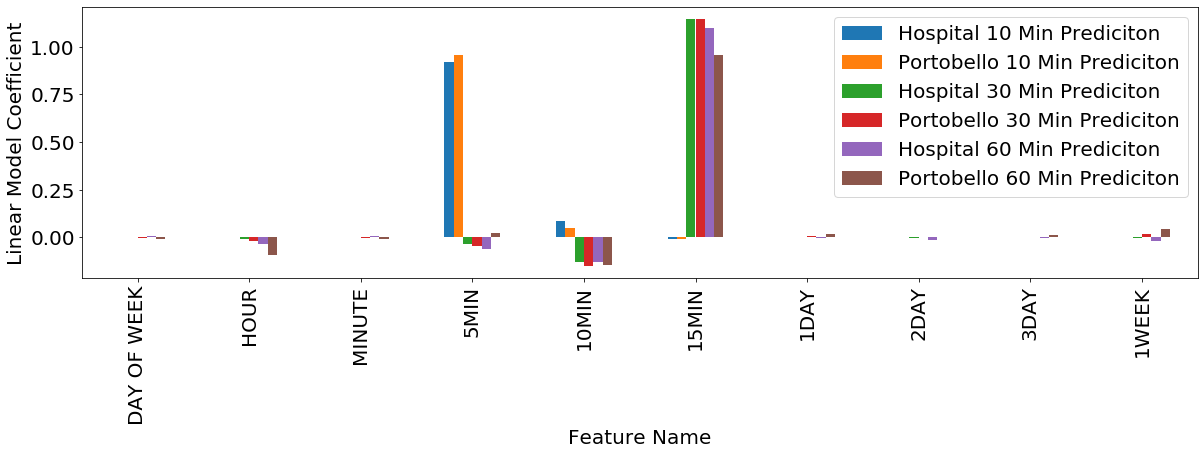

In [213]:
plt.rc('font',size=20)
df.plot.bar(figsize=(20,5))
plt.ylabel("Ridge Regression Model Coefficient")